# Explainability AI - Project

Izard Anne-Solène - Cockenpot Louis - Florval Clément - Gauthier Louis

---

ESILV A4 - CDOF4

### Imports

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np


## Medical Cost Personal Datasets
(https://www.kaggle.com/datasets/mirichoi0218/insurance)

This Kaggle dataset comprises individual insurance costs influenced by various factors like age, sex, BMI, number of children, smoking status, and region.

We are going to try to predict personal insurance charges based on these features, by understanding the impact of personal attributes on insurance costs.

In [3]:
df = pd.read_csv('insurance.csv')
df.head().style.set_caption('First 5 rows of the dataset')


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900000,0,yes,southwest,16884.924000
1,18,male,33.770000,1,no,southeast,1725.552300
2,28,male,33.000000,3,no,southeast,4449.462000
3,33,male,22.705000,0,no,northwest,21984.470610
4,32,male,28.880000,0,no,northwest,3866.855200


In [4]:
df.describe().style.format("{0:.2f}").set_caption("Dataset numerical features description")


,age,bmi,children,charges
count,1338.00,1338.00,1338.00,1338.00
mean,39.21,30.66,1.09,13270.42
std,14.05,6.10,1.21,12110.01
min,18.00,15.96,0.00,1121.87
25%,27.00,26.30,0.00,4740.29
50%,39.00,30.40,1.00,9382.03
75%,51.00,34.69,2.00,16639.91
max,64.00,53.13,5.00,63770.43


In [5]:
def data_info(df):
    data = {
        'Column Name': df.columns,
        'Data Type': [str(df[col].dtype) for col in df.columns],
        'Non-Null Count': df.count().values
    }

    info_df = pd.DataFrame(data)

    return info_df.style.set_caption('Dataset information')

data_info(df)


,Column Name,Data Type,Non-Null Count
0,age,int64,1338
1,sex,object,1338
2,bmi,float64,1338
3,children,int64,1338
4,smoker,object,1338
5,region,object,1338
6,charges,float64,1338


We have no missing values which is good. We have 3 columns with categorical values. We will convert them to numerical values using one hot encoding. We will also normalize the numerical values using StandardScaler. We will start by using a simple linear regression model to predict the price of the hospital charges.

- children: Number of children covered by health insurance / Number of dependents

- bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height, objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9

- charges: Individual medical costs billed by health insurance

### Question 3.
Let’s begin with some visualisations.

• Based on your intuition what are the most important variables for predicting your target variable?

• Create visualisations that take into account the type of variable (categorical, numerical) that show
the correlation of the features you selected.

• Don’t forget to clean your dataset as needed in order to deal with missing values and outliers


---


Intuitively, the most influential variables for predicting insurance costs would be `age`, `BMI`, and `smoking status`.

- Age is very correlates with health risk and medical needs.
- A too high/too low BMI (Body Mass Index) is also directly linked to potential diseases.
- Same for smoking status, which is certainely the most obvious correlated variable.


In [6]:
import plotly.express as px


fig = px.histogram(df, x='charges', marginal="violin",
                   title='Charges Distribution',
                   labels={'charges': 'Charges'},
                   nbins= 100)

fig.update_layout(title_text='Charges Distribution', title_x=0.5,
                  title_font=dict(size=18),
                  bargap=0.05)

fig.show()


The KDE (Kernel Density Estimate) is represented by the line tracing the top of the distribution, providing an estimation of the probability density function of the variable.



In [7]:
fig = px.box(df, y='charges', title='Charges Distribution')
# Show plot
fig.show()


Let's try to straighten the curve so that it looks more like a Gaussian distribution.


Let's compute the logarithmes of the charges and plot its distribution

In [8]:
df_temp = df.copy()
df_temp['charges_log'] = np.log(df_temp['charges'])

fig = px.histogram(df_temp, x='charges_log', marginal="violin",
                   title='Log charges Distribution',
                   labels={'charges_log': 'Log charges'},
                   nbins= 100)

fig.update_layout(title_text='Log charges Distribution', title_x=0.5,
                  title_font=dict(size=18),
                  bargap=0.05)
# Show plot
fig.show()



This is much better

Let's plot the correlation matrix for numerical variables

<Axes: >

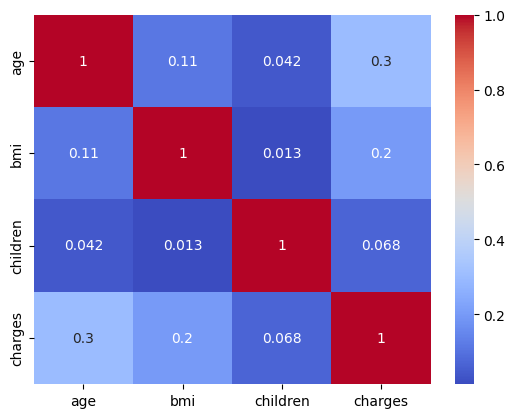

In [9]:
df_numeric = df.select_dtypes(include=[np.number])
corr = df_numeric.corr(method='pearson')
#plotting the correlation
sns.heatmap(corr, annot=True, cmap='coolwarm', cbar=True)


Cleary the charges are highly correlated with age and bmi. This is expected as older people and people with higher bmi are more likely to have health issues and therefore higher charges.

Other distributions

In [10]:
fig = px.scatter(df, x='bmi', y='charges', title='Charges based on BMI',
                   labels={'bmi': 'BMI', 'charges': 'Charges'}, trendline='ols')

for trace in fig.data:
  if trace.mode == "lines":
    trace.line.color = 'red'

fig.update_layout(title_x=0.5,
                    title_font=dict(size=18))

fig.show()


In [11]:
fig = px.scatter(df, x='age', y='charges', color='smoker', title='Charges vs Age',
                  trendline='ols', color_discrete_map={'yes': 'red', 'no': 'blue'})

fig.update_layout(title_x=0.5,
                    title_font=dict(size=18),
                    xaxis_title='Age',
                    yaxis_title='Charges')


In [12]:
# ADD CHARGES IN COMPARIZON TO SEX

fig = px.pie(df, names ='sex', title= 'Distribution of sex in the data')
fig.show()


Here we can see better than on the graph above the distribution of the charges.

In [13]:
import plotly.express as px

fig = px.scatter_matrix(df,
                        dimensions=df.columns,
                        #color='green',
                        title='Pairplot of the DataFrame')

fig.update_traces(diagonal_visible=False,
                  marker=dict(color='green', opacity=0.7, line=dict(color='#aec6cf', width=1)),
                  showupperhalf=False)

fig.update_layout(
    title_x=0.5,
    title='Pairplot of the DataFrame',
    width=1000,
    height=1000
)

fig.show()


### Question 4.
Let’s do a linear regression.

• Do the variable transformations that are needed (on hot encoding, log etc...)

• Fit the linear regression

• Interpret the coefficients of your regression

• Does any coefficient contradict your intuition?


In [14]:
#one hot encoding on the categorical columns
df = pd.get_dummies(df, columns=["sex", "smoker", "region"], drop_first=True)


In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df['bmi'] = scaler.fit_transform(df[['bmi']])
df['age'] = scaler.fit_transform(df[['age']])
df['charges'] = np.log(df['charges'])

df.head(10).style.set_caption("Data for training")


,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,-1.438764,-0.453320,0,9.734176,False,True,False,False,True
1,-1.509965,0.509621,1,7.453302,True,False,False,True,False
2,-0.797954,0.383307,3,8.400538,True,False,False,True,False
3,-0.441948,-1.305531,0,9.998092,True,False,True,False,False
4,-0.513149,-0.292556,0,8.260197,True,False,True,False,False
5,-0.584350,-0.807656,0,8.231275,False,False,False,True,False
6,0.483668,0.455486,1,9.016827,False,False,False,True,False
7,-0.157143,-0.479567,3,8.893093,False,False,True,False,False
8,-0.157143,-0.136714,2,8.765054,True,False,False,False,False
9,1.480485,-0.791252,0,10.272397,False,False,True,False,False


In [16]:
from sklearn.model_selection import train_test_split
y = df['charges']
X = df.drop("charges" , axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)


In [39]:
# Linear regression
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_pred = model.predict(X_test)

y_pred_exp = np.exp(y_pred) # undo log operation
y_test_exp = np.exp(y_test)

mse_linreg = mean_squared_error(y_test_exp, y_pred_exp)
mae_linreg = mean_absolute_error(y_test_exp, y_pred_exp)
r2_linreg = r2_score(y_test_exp, y_pred_exp)

print(f'Mean Squared Error: {mse_linreg}')
print(f'Mean Absolute Error: {mae_linreg}')
print(f'R2 Score: {r2_linreg}')



Mean Squared Error: 54108243.956552915
Mean Absolute Error: 3676.9103647391294
R2 Score: 0.6205616711555837


Coefficients interpretation

In [40]:
coeff_df = pd.DataFrame(model.coef_, X_train.columns, columns=['Coefficient'])
coeff_df = coeff_df.sort_values(by='Coefficient', ascending=False)
coeff_df.style.set_caption('Model Coefficients')


,Coefficient
smoker_yes,1.551698
age,0.480968
children,0.092448
bmi,0.082903
region_northwest,-0.056414
sex_male,-0.074350
region_southwest,-0.122557
region_southeast,-0.136068


As we can see, the column with the highest coeff is smoker_yes, which is coherent with our intuition. Same for age, as we said earlier, it is a key variable for predicting insurance costs because age is directly correlated with health risk and medical needs.

On the other hand, the BMI coeff is lower than expected, even though we noticed earlier a high correlation. It can be explained by the fact that coefficient in a linear regression is influenced not only by the strength of the relationship but also by the scale of the variable and the presence of other variables in the model.


### Question 5.
Let’s build a more complex model

• Build the ”best” model you can using traditional data science (no deep learning)

• Don’t hesitate to fine tune it, try different combination of variables etc

• What is the best metric you can reach? Can you consider it ”good”

• Given your results what use case can be done with this model?


Let's start by listing some models we can use: for this regression we can use linear regression, decision tree, random forest, gradient boosting, support vector machine, k-nearest neighbors etc.
Here the best model will be the one with the best R2 score. We will use cross validation to avoid overfitting. We will also use grid search to find the best hyperparameters for each model.
In this case the best model for this type of data would be random forest or gradient boosting.

In [41]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

param_grid = {'n_estimators': [100, 200, 300, 1000],
                'max_features': ['auto', 'sqrt', 'log2'],
                'max_depth': [10, 30, 50],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4]}      

rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=10)
grid_search.fit(X_train, y_train)

grid_search.best_params_

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV 1/5; 1/324] START max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 1/5; 1/324] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=nan total time=   0.0s
[CV 1/5; 3/324] START max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300
[CV 1/5; 3/324] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300;, score=nan total time=   0.0s
[CV 2/5; 3/324] START max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300
[CV 2/5; 3/324] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300;, score=nan total time=   0.0s
[CV 3/5; 3/324] START max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300
[CV 3/5; 3/324] END max_depth=10, max_features=auto, min_s

/Users/louisgauthier/.virtualenvs/main/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



[CV 5/5; 74/324] END max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.819 total time=   0.2s
[CV 1/5; 75/324] START max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300
[CV 4/5; 71/324] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300;, score=0.753 total time=   0.2s
[CV 5/5; 71/324] START max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300
[CV 4/5; 76/324] END max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=1000;, score=0.793 total time=   1.1s
[CV 5/5; 76/324] START max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=1000
[CV 3/5; 64/324] END max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1000;, score=0.768 total time=   0.7s
[CV 4/5; 64/324] START max_depth=10, max_features=sqrt, min_samples_leaf=

/Users/louisgauthier/.virtualenvs/main/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning:


540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
440 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/louisgauthier/.virtualenvs/main/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/louisgauthier/.virtualenvs/main/lib/python3.11/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/Users/louisgauthier/.virtualenvs/main/lib/python3.11/site-packages/sklearn/base.py", line 666, in

{'max_depth': 50,
 'max_features': 'log2',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 100}

In [42]:
#model evaluation
y_pred = grid_search.predict(X_test)

y_pred_exp = np.exp(y_pred) # undo log operation
y_test_exp = np.exp(y_test)

mse_rf = mean_squared_error(y_test_exp, y_pred_exp)
mae_rf = mean_absolute_error(y_test_exp, y_pred_exp)
r2_rf = r2_score(y_test_exp, y_pred_exp)

print(f'Mean Squared Error: {mse_rf}')
print(f'Mean Absolute Error: {mae_rf}')
print(f'R2 Score: {r2_rf}')

Mean Squared Error: 19523464.41688603
Mean Absolute Error: 2122.1618576343026
R2 Score: 0.86309016575099


In [43]:
# KNN Model

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

knn = KNeighborsRegressor()

param_grid = {'n_neighbors': [3, 5, 7, 9, 11],  
              'weights': ['uniform', 'distance'],
              'metric': ['euclidean', 'manhattan']}

grid_search_knn = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, n_jobs=-1, verbose=10)
grid_search_knn.fit(X_train, y_train)

grid_search_knn.best_params_

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5; 1/20] START metric=euclidean, n_neighbors=3, weights=uniform...........
[CV 2/5; 1/20] START metric=euclidean, n_neighbors=3, weights=uniform...........
[CV 1/5; 1/20] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.664 total time=   0.0s
[CV 2/5; 1/20] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.766 total time=   0.0s
[CV 3/5; 1/20] START metric=euclidean, n_neighbors=3, weights=uniform...........
[CV 4/5; 1/20] START metric=euclidean, n_neighbors=3, weights=uniform...........
[CV 5/5; 1/20] START metric=euclidean, n_neighbors=3, weights=uniform...........
[CV 3/5; 1/20] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.588 total time=   0.0s
[CV 1/5; 2/20] START metric=euclidean, n_neighbors=3, weights=distance..........
[CV 4/5; 1/20] END metric=euclidean, n_neighbors=3, weights=uniform;, score=0.626 total time=   0.0s
[CV 2/5; 2/20] START metric=euclidean, n_neighbo

{'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}

In [44]:
# model evaluation
y_pred = grid_search_knn.predict(X_test)

y_pred_exp = np.exp(y_pred) # undo log operation
y_test_exp = np.exp(y_test)

mse_knn = mean_squared_error(y_test_exp, y_pred_exp)
mae_knn = mean_absolute_error(y_test_exp, y_pred_exp)
r2_knn = r2_score(y_test_exp, y_pred_exp)

print(f'Mean Squared Error: {mse_knn}')
print(f'Mean Absolute Error: {mae_knn}')
print(f'R2 Score: {r2_knn}')

Mean Squared Error: 52705921.87474107
Mean Absolute Error: 3808.1200563775665
R2 Score: 0.6303955653705127


Let's use XGBRegressor. We use GridSearchCV for hyperparameter tuning locally.

In [45]:
from xgboost import XGBRegressor

xgb = XGBRegressor(eval_metric="mae", early_stopping_rounds=10,
                   colsample_bytree=0.8, learning_rate=0.01,
                   max_depth=5, n_estimators=1000,
                   subsample=0.7)

xgb.fit(X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric='mae', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Model evaluation

In [46]:
y_pred = xgb.predict(X_test)

y_pred_exp = np.exp(y_pred) # undo log operation
y_test_exp = np.exp(y_test)

mse_xgb = mean_squared_error(y_test_exp, y_pred_exp)
mae_xgb = mean_absolute_error(y_test_exp, y_pred_exp)
r2_xgb = r2_score(y_test_exp, y_pred_exp)

print(f'Mean Squared Error: {mse_xgb}')
print(f'Mean Absolute Error: {mae_xgb}')
print(f'R2 Score: {r2_xgb}')


Mean Squared Error: 18544054.54190877
Mean Absolute Error: 1931.0505676146793
R2 Score: 0.8699583547558576


A mean absolute error of 2045 is quite good knowing the std of the charges is 12000. The R2 score is also quite good, 0.86. This means that 86% of the variance in the charges can be explained by the model.

In [47]:
# Perform a grid search to find the best parameters

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Split the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Perform a grid search to find the best parameters
grid = GridSearchCV(XGBRegressor(eval_metric="mae", early_stopping_rounds=10),
                    param_grid, verbose=3, n_jobs=-1)

# Fit the grid search on the training data
grid.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

# Show the best parameters
display(grid.best_params_)

# Evaluate the model with the best parameters
y_pred = grid.predict(X_test)

y_pred_exp = np.exp(y_pred) # undo log operation
y_test_exp = np.exp(y_test)

mse_xgb_grid = mean_squared_error(y_test_exp, y_pred_exp)
mae_xgb_grid = mean_absolute_error(y_test_exp, y_pred_exp)
r2_xgb_grid = r2_score(y_test_exp, y_pred_exp)

print(f'Mean Squared Error: {mse_xgb_grid}')
print(f'Mean Absolute Error: {mae_xgb_grid}')
print(f'R2 Score: {r2_xgb_grid}')


Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7;, score=0.608 total time=   0.0s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7;, score=0.562 total time=   0.0s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7;, score=0.545 total time=   0.0s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7;, score=0.540 total time=   0.0s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7;, score=0.562 total time=   0.0s
[CV 1/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.9;, score=0.545 total time=   0.0s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8;, score=0.539 total time=   0.0s
[CV 5

/Users/louisgauthier/.virtualenvs/main/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



[CV 4/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=1000, subsample=0.9;, score=0.774 total time=   0.0s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=1000, subsample=0.9;, score=0.765 total time=   0.5s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=1000, subsample=0.9;, score=0.802 total time=   0.0s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.01, max_depth=7, n_estimators=1000, subsample=0.9;, score=0.869 total time=   0.5s
[CV 4/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.7;, score=0.764 total time=   0.1s
[CV 2/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.7;, score=0.860 total time=   0.1s
[CV 3/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.8;, score=0.754 total time=   0.0s
[CV 5/5] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_e

{'colsample_bytree': 0.9,
 'learning_rate': 0.01,
 'max_depth': 3,
 'n_estimators': 500,
 'subsample': 0.7}

Mean Squared Error: 18227314.293031357
Mean Absolute Error: 1864.8362329598297
R2 Score: 0.8721795207358201


Grid search improved the model by 0.01 on the R2 score and 140 on the mean absolute error.

In [69]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Assuming mse_linreg, mse_rf, ... , r2_xgb_grid are defined variables with your metric scores

# Create subplots: 1 row, 3 columns
fig = make_subplots(rows=1, cols=3, shared_xaxes=True,
                    subplot_titles=('Mean Squared Error', 'Mean Absolute Error', 'R2 Score'))

# Add traces for MSE
fig.add_trace(go.Bar(x=['Linear Regression', 'Random Forest', 'KNN', 'XGBoost', 'XGBoost Grid'],
                     y=[mse_linreg, mse_rf, mse_knn, mse_xgb, mse_xgb_grid],
                     name='MSE', marker_color='indianred'), row=1, col=1)

# Add traces for MAE
fig.add_trace(go.Bar(x=['Linear Regression', 'Random Forest', 'KNN', 'XGBoost', 'XGBoost Grid'],
                     y=[mae_linreg, mae_rf, mae_knn, mae_xgb, mae_xgb_grid],
                     name='MAE', marker_color='lightsalmon'), row=1, col=2)

# Add traces for R2 Score
fig.add_trace(go.Bar(x=['Linear Regression', 'Random Forest', 'KNN', 'XGBoost', 'XGBoost Grid'],
                     y=[r2_linreg, r2_rf, r2_knn, r2_xgb, r2_xgb_grid],
                     name='R2', marker_color='lightcoral'), row=1, col=3)

# Update layout
fig.update_layout(title='Model Comparison', title_x=0.5, title_font=dict(size=18),
                  xaxis_tickangle=-45, xaxis2_tickangle=-45, xaxis3_tickangle=-45)

# Update y-axes titles
fig.update_yaxes(title_text='MSE', row=1, col=1)
fig.update_yaxes(title_text='MAE', row=1, col=2)
fig.update_yaxes(title_text='R2 Score', row=1, col=3)

fig.show()


### Question 6.
Using shapley values explain your model
- Start by giving some forceplot examples
- Use the feature importance and identify the most important variables
- Compare them to the variables identified in the linear regression
- Using the beeswarm plot explain the model behaviour for the most important variables
- Use dependance plots in order to understand the behaviour of the most important variables

Calculating shapeley values

In [24]:
import shap

explainer = shap.Explainer(xgb)
shap_values = explainer.shap_values(X_test)


/Users/louisgauthier/.virtualenvs/main/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



**Forceplot examples**

First row

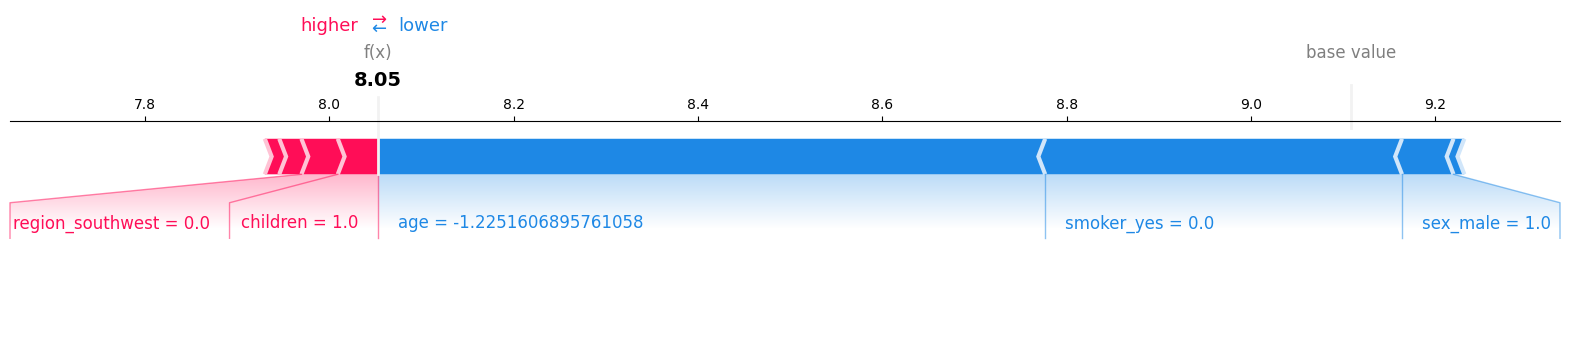

In [25]:
shap.plots.force(explainer.expected_value, shap_values[0], X_test.iloc[0], matplotlib = True)


We can see that the age of this person has a positive impact on the charges, meaning that this person is not young and is likely to have more health problems.

In the other hand, the fact that this person is not a smoker has a negative impact on the charges.

11th row

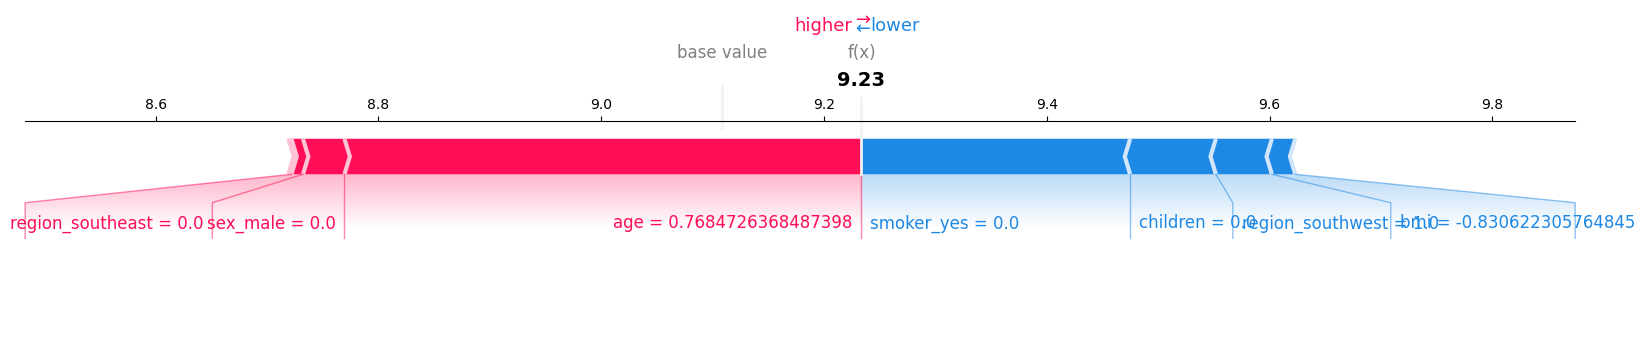

In [26]:
shap.plots.force(explainer.expected_value, shap_values[10], X_test.iloc[10], matplotlib = True)


28th row

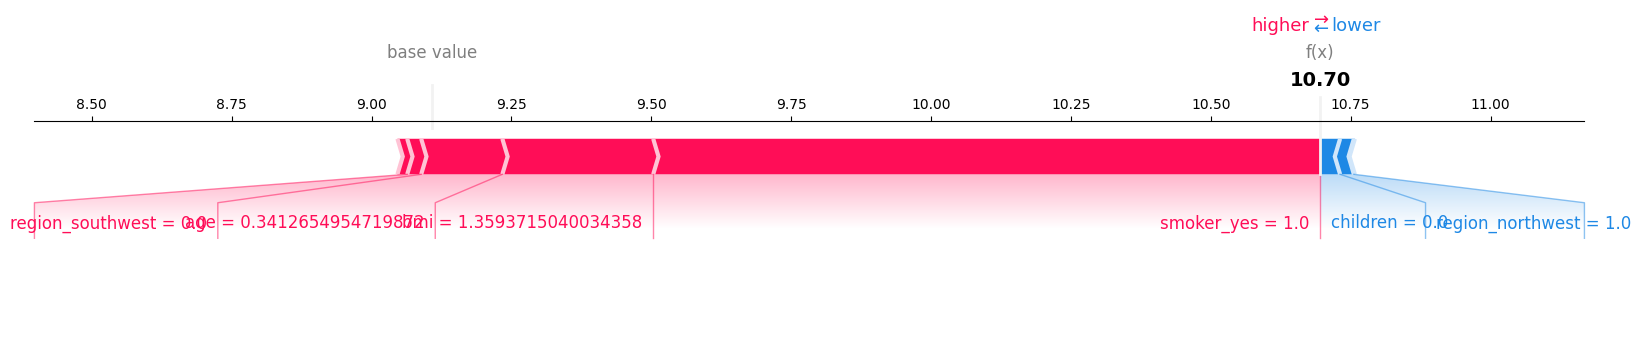

In [27]:
shap.plots.force(explainer.expected_value, shap_values[27], X_test.iloc[27], matplotlib = True)


**Global feature importance**

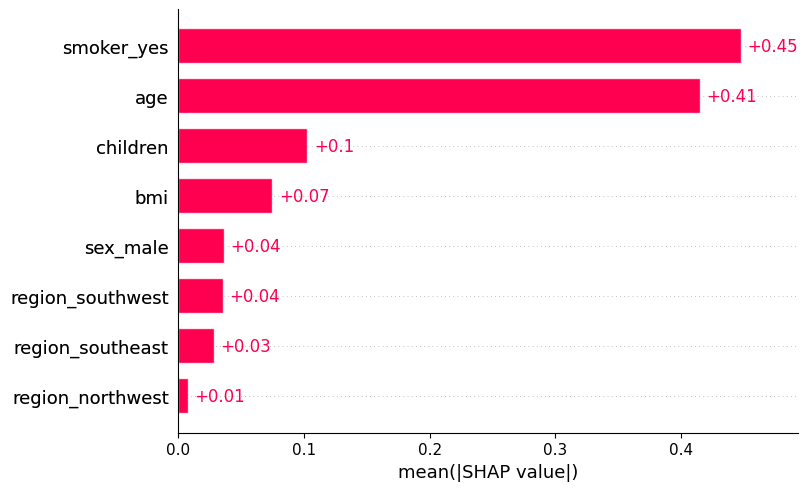

In [28]:
shaps = explainer(X_test)
shap.plots.bar(shaps)


As we can see, the feature importance of this XGBRegressor model is mostly the same as the linear regression model. 

The two most important features are smoker_yes and age.

The sex has taken one position compared to the linear regression model, but it is still not very important.

**Beeswarm plot**

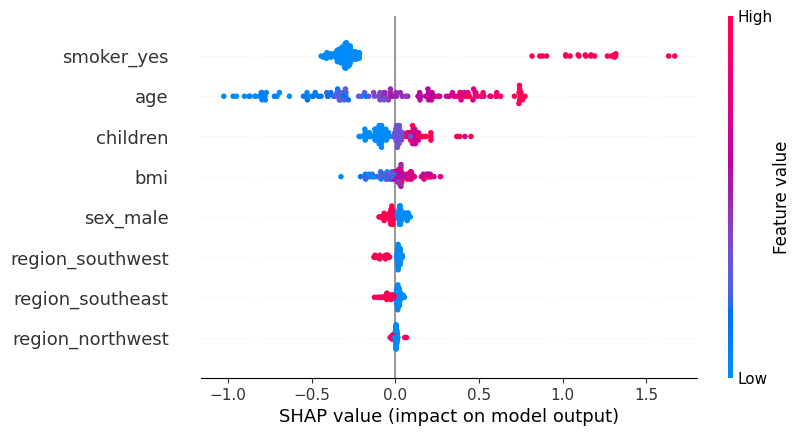

In [29]:
shap.plots.beeswarm(shaps)


**Dependance plots**

For the most important feature: `smoker_yes`

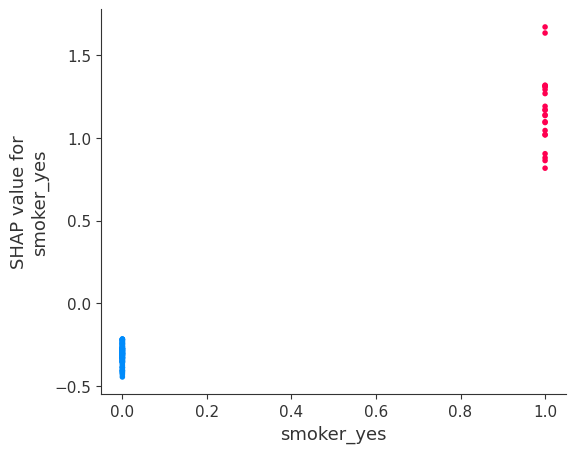

In [30]:
shap.dependence_plot("smoker_yes", shap_values, X_test, interaction_index='smoker_yes')


For the second most important feature: `age`

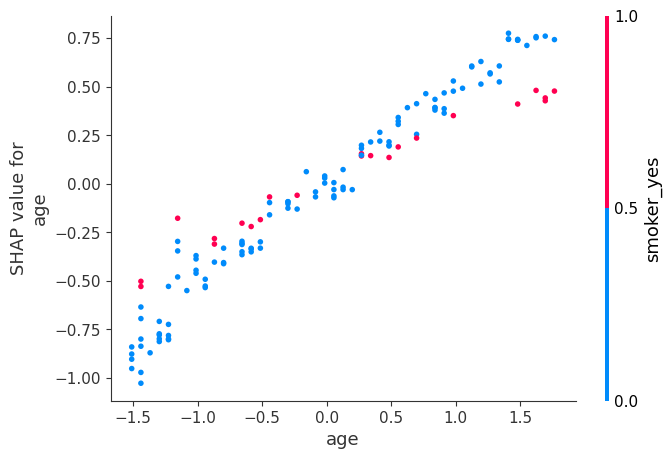

In [31]:
shap.dependence_plot("age", shap_values, X_test, interaction_index='smoker_yes')


`BMI`

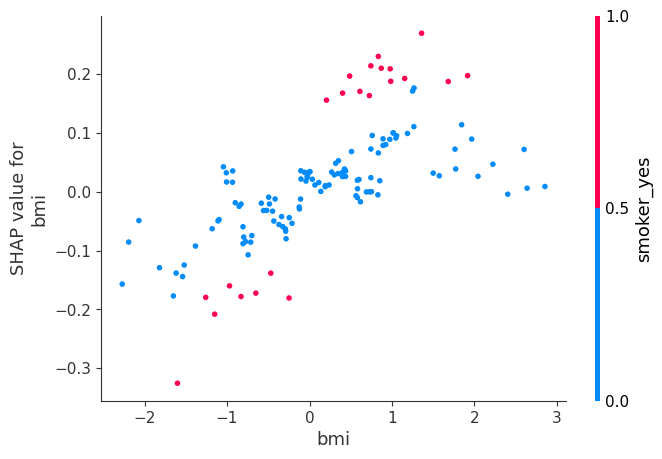

In [32]:
shap.dependence_plot("bmi", shap_values, X_test, interaction_index='smoker_yes')


### Question 7.
We will now do a clusteirng of shapley values.
- Let’s reduce the dimension of our data for visualisation purposes. Do a PCA with the shapley values
and visualise the 2 principal axis.
- Given the visualisation choose a clustering algorithm (K-Means, DBSCAN, gausian mixture...) and
try to cluster the shapley values of the property.
- Visualise your results
- What characteristics can you give to each cluster?
- What conclusion can you reach?


Dimension reduction - PCA

In [33]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(shap_values)

principalDf = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])

fig = px.scatter(principalDf, x='principal component 1', y='principal component 2',
                 title='2 Component PCA', 
                 width=800, height=800)

fig.update_layout(xaxis_title='Principal Component 1', 
                  yaxis_title='Principal Component 2',
                  title_x=0.5)

fig.show()


Shap values clustering

In [34]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(shap_values)

principalDf['cluster'] = clusters

fig = px.scatter(principalDf, x='principal component 1', y='principal component 2', color='cluster',
                 title='2 Component PCA with DBSCAN Clusters', 
                 width=800, height=800, color_continuous_scale='viridis_r')

fig.update_layout(xaxis_title='Principal Component 1', 
                  yaxis_title='Principal Component 2',
                  title_x=0.5)

fig.show()
